In [9]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from langchain_ollama import OllamaLLM, ChatOllama, OllamaEmbeddings
from langchain_chroma import Chroma
from typing_extensions import List, TypedDict


In [10]:
llm = ChatOllama(model = "llama3.2")

In [11]:
embeddings = OllamaEmbeddings(model="llama3.2")

In [12]:
# Define prompt for question-answering
print("Pulling Prompt...")
prompt = hub.pull("rlm/rag-prompt")
prompt

Pulling Prompt...


/home/dgracias/.local/lib/python3.12/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [13]:
# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [14]:
def load_documents(vector_store):
    # Load and chunk contents of the blog
    print("Loading Documents...")
    loader = WebBaseLoader(
        web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
        bs_kwargs=dict(
            parse_only=bs4.SoupStrainer(
                class_=("post-content", "post-title", "post-header")
            )
        ),
    )
    docs = loader.load()

    print("Splitting Text...")
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    all_splits = text_splitter.split_documents(docs)

    # Index chunks
    print("Adding Documents to Vector Store...")
    vector_store = Chroma.from_documents(
        all_splits,
        embeddings,
        collection_name="test2",
        persist_directory="./chroma_langchain_db"
    )
    

    print(f"Total documents in vector store: {len(vector_store.get()["ids"])}")

    return vector_store

In [15]:
vector_store = Chroma(embedding_function=embeddings, persist_directory="./chroma_langchain_db")
print(f"Total documents in vector store: {len(vector_store.get()["ids"])}")

Total documents in vector store: 1539


In [ ]:
# load_documents(vector_store)

In [ ]:
# from langchain_unstructured import UnstructuredLoader
# loader = UnstructuredLoader(
#     file_path="../backend/data/california-diet-manual.pdf",
#     strategy="hi_res",
# )

In [ ]:
# docs = loader.lazy_load()

In [ ]:
# new_docs = []
# for doc in docs:
#     new_docs.append(doc)
#     print(doc, end="\n-----\n")

In [ ]:
# type(new_docs[0])

In [ ]:
# from langchain_community.vectorstores.utils import filter_complex_metadata

# vector_store.add_documents(filter_complex_metadata(new_docs))

In [18]:
# Define application steps
def retrieve(state: State):
    global vector_store

    print("Retriving...")

    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    global vector_store
    
    print("Generating...")

    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    print(response)
    return {"answer": response}

In [19]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

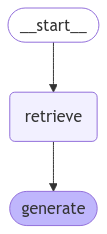

In [20]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
response = graph.invoke({"question": "Give me basic menu framework"})
print(response)

Retriving...
Generating...
content="I don't have enough context to provide a basic menu framework. The retrieved information only mentions diet principles, but not specific nutritional guidelines or meal planning recommendations. I would need more information about the specific dietary needs or restrictions to provide an accurate answer." additional_kwargs={} response_metadata={'model': 'llama3.2', 'created_at': '2024-11-29T09:47:15.699119428Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 3312208628, 'load_duration': 54730823, 'prompt_eval_count': 122, 'prompt_eval_duration': 129000000, 'eval_count': 50, 'eval_duration': 3126000000} id='run-3cf2464f-4f66-4983-a44f-c8ef5df690ca-0' usage_metadata={'input_tokens': 122, 'output_tokens': 50, 'total_tokens': 172}
{'question': 'Give me basic menu framework', 'context': [Document(metadata={'category': 'ListItem', 'detection_class_prob': 0.9110511541366577, 'element_id': '4db2c02c0b5db

In [22]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response)

Retriving...
Generating...
content="I don't know the definition of Task Decomposition. The provided context appears to be related to nutrition and diet principles, but it does not mention Task Decomposition. If you could provide more context or information about where Task Decomposition is used, I may be able to help further." additional_kwargs={} response_metadata={'model': 'llama3.2', 'created_at': '2024-11-29T09:47:19.748492409Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 3919636621, 'load_duration': 46368486, 'prompt_eval_count': 139, 'prompt_eval_duration': 130000000, 'eval_count': 58, 'eval_duration': 3742000000} id='run-4c5a34e7-bb4d-42c7-9cfa-f5ec1af43667-0' usage_metadata={'input_tokens': 139, 'output_tokens': 58, 'total_tokens': 197}
{'question': 'What is Task Decomposition?', 'context': [Document(metadata={'category': 'ListItem', 'detection_class_prob': 0.8160165548324585, 'element_id': '41b19915d429e7edb79416e9ab

In [23]:
response["answer"]

AIMessage(content="I don't know the definition of Task Decomposition. The provided context appears to be related to nutrition and diet principles, but it does not mention Task Decomposition. If you could provide more context or information about where Task Decomposition is used, I may be able to help further.", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-11-29T09:47:19.748492409Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 3919636621, 'load_duration': 46368486, 'prompt_eval_count': 139, 'prompt_eval_duration': 130000000, 'eval_count': 58, 'eval_duration': 3742000000}, id='run-4c5a34e7-bb4d-42c7-9cfa-f5ec1af43667-0', usage_metadata={'input_tokens': 139, 'output_tokens': 58, 'total_tokens': 197})

# Part 2

In [24]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [25]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [26]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind(functions=[retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])

# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [27]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

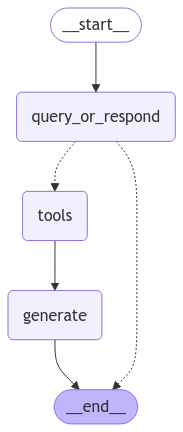

In [28]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

How can I assist you today?


In [ ]:
input_message = "Give me the table for BASIC MENU FRAMEWORK HOUSE DIET 2000 – 2500 KCAL"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

In [31]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [ ]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config
):
    step["messages"][-1].pretty_print()

In [35]:
for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    print(step, end="\n------\n")

{'messages': [HumanMessage(content='What is the standard method for Task Decomposition?\n\nOnce you get the answer, look up common extensions of that method.', additional_kwargs={}, response_metadata={}, id='b445a187-495b-4ffa-afaa-ed856fe5f161'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-11-29T09:48:54.39368118Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'retrieve', 'arguments': {'query': 'Task Decomposition standard method'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 1904855750, 'load_duration': 41616289, 'prompt_eval_count': 175, 'prompt_eval_duration': 178000000, 'eval_count': 20, 'eval_duration': 1683000000}, id='run-ec3fd8a6-3b2d-4ac1-9edd-636bcc00c360-0', tool_calls=[{'name': 'retrieve', 'args': {'query': 'Task Decomposition standard method'}, 'id': '12485da0-3341-4dd4-9cfb-53704c944f9f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 175, 'output_to

In [ ]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    for chunk in step["messages"][-1]:
        print(chunk, end="|", flush=True)

In [ ]:
input_message = "Give me an overview fo LLM powered autonomous agents?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    print(step["messages"])

In [ ]:
for step in graph.astream(

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

In [ ]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [36]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

result = None

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()
    result = event["messages"]

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (8e30c117-b38c-48bc-ac29-d614dcbb7750)
 Call ID: 8e30c117-b38c-48bc-ac29-d614dcbb7750
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'category': 'Title', 'detection_class_prob': 0.4450242221355438, 'element_id': '8c5c926a4f44ed77bc4d416ad58ade4d', 'file_directory': '../backend/data', 'filename': 'california-diet-manual.pdf', 'filetype': 'application/pdf', 'last_modified': '2024-11-28T15:38:13', 'page_number': 15, 'parent_id': '45273bed427e6548430612c3f7780cf7', 'source': '../backend/data/california-diet-manual.pdf'}
Content: Approximate Composition

Source: {'category': 

In [ ]:
step

# Colpali Test

In [ ]:
from typing import cast

import torch

from PIL import Image
from colpali_engine.models import ColPali, ColPaliProcessor

model_name = "vidore/colpali-v1.2"

model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",
).eval()

In [ ]:
processor = ColPaliProcessor.from_pretrained(model_name)

In [ ]:
images = [
    Image.new("RGB", (32, 32), color="white"),
    Image.new("RGB", (32, 32), color="black")
]

queries= [
    "Is attnetion really all you need?",
    "Are Benjamin, Antoine, Merve and Jo best friends?"
]

In [ ]:
batch_images = processor.process_images(images).to(model.device)
batch_queries = processor.process_queries(queries).to(model.device)

In [ ]:
with torch.no_grad():
    image_embeddings = model(**batch_images)
    query_embeddings = model(**batch_queries)

In [ ]:
scores = processor.score_multi_vector(query_embeddings, image_embeddings)